In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from utils.utils_models import LightGBMForecastingModel

import utils.utils_preprocessing as utils_preprocessing
from utils.utils_features_classical_methods import features_time_related, features_lag, create_periods_feature

### Load data

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

### Preprocessing

In [3]:
df = utils_preprocessing.set_types(df)

In [4]:
df_monthly = utils_preprocessing.aggregate_data(df, frequency="ME")
df_monthly = utils_preprocessing.fill_in_missing_dates(df_monthly, group_col=["brand", "family"], date_col="date", freq="ME")

In [5]:
df_monthly

,brand,family,date,total_revenue
0,Columbia,Bañadores Natación,2021-09-30,99.949997
1,Columbia,Bañadores Natación,2021-10-31,99.949997
2,Columbia,Bañadores Natación,2021-11-30,99.949997
3,Columbia,Bañadores Natación,2021-12-31,99.949997
4,Columbia,Bañadores Natación,2022-01-31,99.949997
...,...,...,...,...
3500,adidas,Zuecos Urban,2024-03-31,99.949997
3501,adidas,Zuecos Urban,2024-04-30,99.949997
3502,adidas,Zuecos Urban,2024-05-31,199.899994
3503,adidas,Zuecos Urban,2024-06-30,99.949997


### Features generation

In [6]:
df_monthly = features_time_related(df_monthly, frequency='ME')
df_monthly = features_lag(
    df=df_monthly, 
    col="total_revenue",
    lags=[12, 13, 14],
    group_column=['brand', 'family']
)
df_monthly = create_periods_feature(df_monthly, group_col=['brand', 'family'], date_col='date', target_col='total_revenue')

In [7]:
df_monthly

,brand,family,date,total_revenue,year,month_of_year,sin_month_of_year,cos_month_of_year,total_revenue_lag_12,total_revenue_lag_13,total_revenue_lag_14,feature_periods
0,Columbia,Bañadores Natación,2021-09-30,99.949997,2021,9,-1.000,-0.000,NaN,NaN,NaN,1.0
1,Columbia,Bañadores Natación,2021-10-31,99.949997,2021,10,-0.866,0.500,NaN,NaN,NaN,2.0
2,Columbia,Bañadores Natación,2021-11-30,99.949997,2021,11,-0.500,0.866,NaN,NaN,NaN,3.0
3,Columbia,Bañadores Natación,2021-12-31,99.949997,2021,12,-0.000,1.000,NaN,NaN,NaN,4.0
4,Columbia,Bañadores Natación,2022-01-31,99.949997,2022,1,0.500,0.866,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3500,adidas,Zuecos Urban,2024-03-31,99.949997,2024,3,1.000,0.000,99.949997,99.949997,99.949997,32.0
3501,adidas,Zuecos Urban,2024-04-30,99.949997,2024,4,0.866,-0.500,299.849976,99.949997,99.949997,33.0
3502,adidas,Zuecos Urban,2024-05-31,199.899994,2024,5,0.500,-0.866,299.849976,299.849976,99.949997,34.0
3503,adidas,Zuecos Urban,2024-06-30,99.949997,2024,6,0.000,-1.000,299.849976,299.849976,299.849976,35.0


### Hyperparameters evaluation

In [8]:
cols_categorical = ['brand', 'family']
for col in cols_categorical:
    df_monthly[col] = df_monthly[col].astype("category")
df_monthly = df_monthly.rename(columns={"total_revenue": "y"}).set_index("date")

In [9]:
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [10]:
X_test.index.min(), X_test.index.max()

(Timestamp('2023-10-31 00:00:00'), Timestamp('2024-09-30 00:00:00'))

In [11]:
cv_split = TimeSeriesSplit(n_splits=3, test_size=12)

In [12]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    'verbosity': [-1],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=12),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'verbosity': [-1]},
                   verbose=1)

In [13]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [14]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1,
 'importance_type': 'split',
 'learning_rate': 0.5,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_leaves': 120,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 10,
 'reg_lambda': 50,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

### Model evaluation

In [15]:
tss = TimeSeriesSplit(2, test_size=12)

fc_model = LightGBMForecastingModel(hyperparameters=optimal_params)
results_cv = fc_model.cross_validate(df_monthly, n_splits=2)

Train [2020-09-30 - 2022-09-30]
Predict [2022-10-31 - 2023-09-30]
Train [2020-09-30 - 2023-09-30]
Predict [2023-10-31 - 2024-09-30]
Average RMSE from cross-validation: 2222.5865


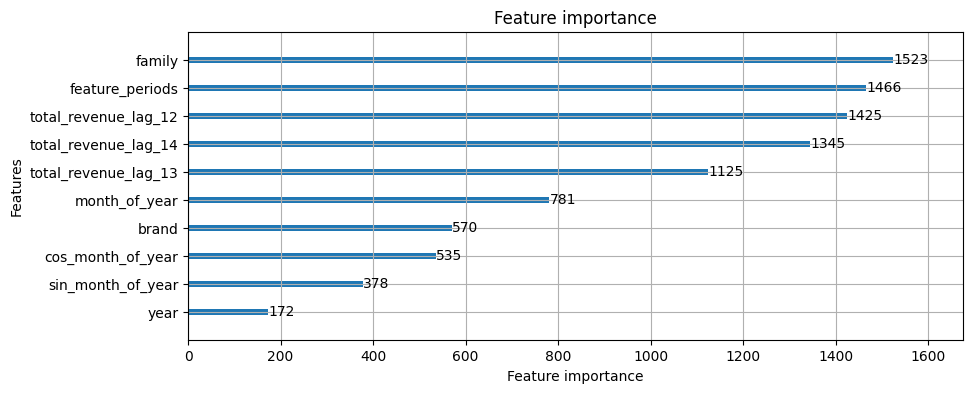

In [16]:
fc_model.plot_feature_importance()

In [17]:
# X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [18]:
# fc_model = LightGBMForecastingModel(hyperparameters=optimal_params)
# fc_model.train(X_train, y_train)

### Plot predictions

In [19]:
y_preds = fc_model.predict(X=X_test)
df_preds = pd.DataFrame(
    data={
        "brand": X_test["brand"],
        "family": X_test["family"],
        "y_pred": y_preds,
        "y": y_test.values
    },
    index=X_test.index,
)

In [20]:
df_preds.index.min()

Timestamp('2023-10-31 00:00:00')

In [21]:
df_preds.index.max()

Timestamp('2024-09-30 00:00:00')

<Axes: xlabel='date'>

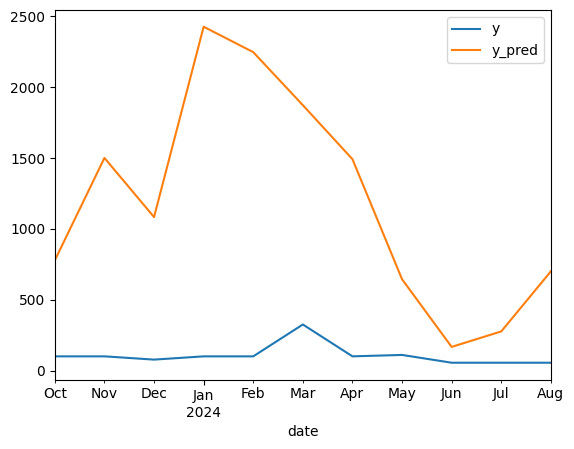

In [22]:
family = "Calcetines Running"
brand = "adidas"
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)][["y", "y_pred"]].plot()

In [26]:
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)][["y", "y_pred"]]

,y,y_pred
date,,
2023-10-31,100.000000,777.938057
2023-11-30,100.000000,1500.885662
2023-12-31,77.000000,1083.351156
2024-01-31,99.949997,2427.201540
2024-02-29,99.949997,2247.684720
2024-03-31,324.950012,1873.343622
2024-04-30,100.000000,1491.916839
2024-05-31,110.000000,644.426173
2024-06-30,55.000000,166.717156


In [23]:
df_monthly[["brand", "family"]].value_counts().head(50)

brand     family                                
adidas    Camisetas Urban                           49
          Camisetas Training                        49
          Bañadores Natación                        49
          Tops y Sujetadores deportivos Training    49
Columbia  Zapatillas de montaña                     49
          Zapatillas Trail Running                  49
adidas    Camisetas Running                         49
          Zapatillas Running                        49
          Pantalones Urban                          49
          Zapatillas Trail Running                  49
          Mallas y pantalones Training              49
          Zapatillas Urban                          49
Columbia  Camisetas Outdoor                         49
adidas    Zapatillas de montaña                     49
Columbia  Botas de montaña                          49
adidas    Botas de montaña                          48
          Chaquetas Running                         48
          Chánda